In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import re
import nltk
from nltk.corpus import stopwords


In [3]:
print("\n" + "="*50)
print("STEP 1: Data Preparation")
print("="*50)

# Download stopwords if needed
nltk.download('stopwords')

# Set random seed for reproducibility
np.random.seed(1409)
tf.random.set_seed(764)

print("Loading IMDB dataset...")
# Load the IMDB dataset with Keras (top 10,000 words)
num_words = 500000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=num_words)

# Convert the sequences back to text
word_index = imdb.get_word_index()
# Create a reverse mapping
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def sequence_to_text(sequence):
    # Add 3 because 0, 1, and 2 are reserved indices for padding, start, and unknown
    return ' '.join([reverse_word_index.get(i - 3, '?') for i in sequence if i > 3])

# Convert sequences to text
X_train_text = [sequence_to_text(seq) for seq in X_train]
X_test_text = [sequence_to_text(seq) for seq in X_test]

print(f"Training examples: {len(X_train_text)}, Test examples: {len(X_test_text)}")

# Optional: Print a few examples to examine the data
print("\nSample reviews:")
for i in range(2):
    print(f"Review {i+1}: {X_train_text[i][:200]}...")
    print(f"Sentiment: {'Positive' if y_train[i] == 1 else 'Negative'}")
    print()



STEP 1: Data Preparation
Loading IMDB dataset...


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Training examples: 25000, Test examples: 25000

Sample reviews:
Review 1: this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now ...
Sentiment: Positive

Review 2: big hair big boobs bad music and a giant safety pin these are the words to best describe this terrible movie i love cheesy horror movies and i've seen hundreds but this had got to be on of the worst e...
Sentiment: Negative



In [4]:
print("\n" + "="*50)
print("STEP 2: Text Preprocessing")
print("="*50)

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation and numbers
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = text.split()
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

# Apply preprocessing to both training and test sets
print("Preprocessing text data...")
X_train_processed = [preprocess_text(text) for text in X_train_text]
X_test_processed = [preprocess_text(text) for text in X_test_text]

# Print a before/after example
print("\nPreprocessing example:")
print(f"Original: {X_train_text[0][:200]}...")
print(f"Processed: {X_train_processed[0][:200]}...")



STEP 2: Text Preprocessing
Preprocessing text data...

Preprocessing example:
Original: this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now ...
Processed: film brilliant casting location scenery story direction everyones really suited part played could imagine robert redfords amazing actor director normans father came scottish island loved fact real con...


In [5]:
print("\n" + "="*50)
print("STEP 3: Feature Extraction")
print("="*50)

print("Extracting TF-IDF features...")
tfidf_vectorizer = TfidfVectorizer(max_features=10000)  # Reduced to make neural network training more efficient
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_processed)
X_test_tfidf = tfidf_vectorizer.transform(X_test_processed)

print(f"Feature matrix shape: {X_train_tfidf.shape}")
print(f"Number of unique terms: {len(tfidf_vectorizer.get_feature_names_out())}")

# Convert sparse matrix to dense for Keras
X_train_tfidf_dense = X_train_tfidf.toarray()
X_test_tfidf_dense = X_test_tfidf.toarray()

# Create a validation set for the neural network
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_tfidf_dense, y_train, test_size=0.2, random_state=42
)

print(f"Training set shape: {X_train_final.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test_tfidf_dense.shape}")



STEP 3: Feature Extraction
Extracting TF-IDF features...
Feature matrix shape: (25000, 10000)
Number of unique terms: 10000
Training set shape: (20000, 10000)
Validation set shape: (5000, 10000)
Test set shape: (25000, 10000)


In [6]:
print("\n" + "="*50)
print("STEP 4: Logistic Regression Model (Baseline)")
print("="*50)

print("Training logistic regression model...")
lr_model = LogisticRegression(max_iter=5000)
lr_model.fit(X_train_tfidf, y_train)

print("Evaluating logistic regression model...")
y_pred = lr_model.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
print(f"Logistic Regression Accuracy: {accuracy:.4f}")
print("\nClassification Report (Logistic Regression):")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))


STEP 4: Logistic Regression Model (Baseline)
Training logistic regression model...
Evaluating logistic regression model...
Logistic Regression Accuracy: 0.8830

Classification Report (Logistic Regression):
              precision    recall  f1-score   support

    Negative       0.88      0.88      0.88     12500
    Positive       0.88      0.88      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000



In [7]:
print("\n" + "="*50)
print("STEP 5: Neural Network Model Building")
print("="*50)

print("Building neural network model...")
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_tfidf_dense.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print(model.summary())



STEP 5: Neural Network Model Building
Building neural network model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 128)            │     1,280,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,288,449 (4.92 MB)

 Trainable params: 1,288,449 (4.92 MB)

 Non-trainable params: 0 (0.00 B)

None


In [8]:
print("\n" + "="*50)
print("STEP 6: Neural Network Training with Epochs")
print("="*50)

# Define the training parameters
epochs = 10
batch_size = 64

# Train the model with history tracking
print("Training neural network model...")
history = model.fit(
    X_train_final, y_train_final,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    verbose=1
)


STEP 6: Neural Network Training with Epochs
Training neural network model...
Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.7718 - loss: 0.4982 - val_accuracy: 0.8882 - val_loss: 0.2645
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.9238 - loss: 0.2059 - val_accuracy: 0.8784 - val_loss: 0.2986
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - accuracy: 0.9573 - loss: 0.1283 - val_accuracy: 0.8738 - val_loss: 0.3535
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.9793 - loss: 0.0708 - val_accuracy: 0.8720 - val_loss: 0.4230
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.9882 - loss: 0.0406 - val_accuracy: 0.8692 - val_loss: 0.5155
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.9950 - loss: 0.0207 - val_accuracy: 0.8692 - val_loss: 0.5830
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.9966 - loss: 0.0124 - val_accuracy: 0.8670 - val_loss: 0.6695
Epoch 8/10
313/3

In [9]:
print("\n" + "="*50)
print("STEP 7: Neural Network Evaluation")
print("="*50)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test_tfidf_dense, y_test, verbose=0)
print(f"Neural Network Test Accuracy: {test_accuracy:.4f}")

# Predictions
y_pred_prob = model.predict(X_test_tfidf_dense)
y_pred_nn = (y_pred_prob > 0.5).astype(int).flatten()

print("\nClassification Report (Neural Network):")
print(classification_report(y_test, y_pred_nn, target_names=['Negative', 'Positive']))



STEP 7: Neural Network Evaluation
Neural Network Test Accuracy: 0.8482
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step

Classification Report (Neural Network):
              precision    recall  f1-score   support

    Negative       0.84      0.86      0.85     12500
    Positive       0.85      0.84      0.85     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000




STEP 8: Visualization


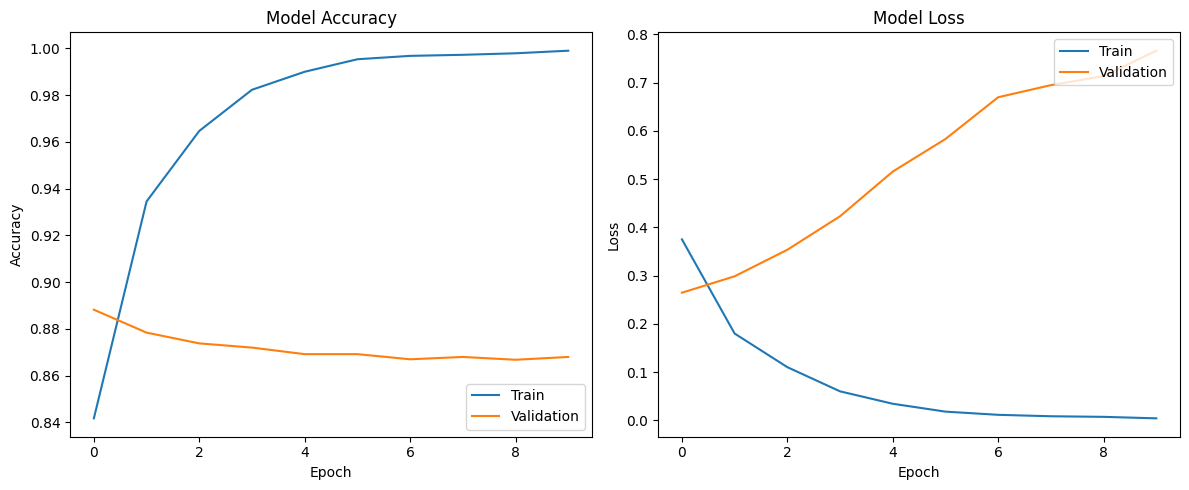

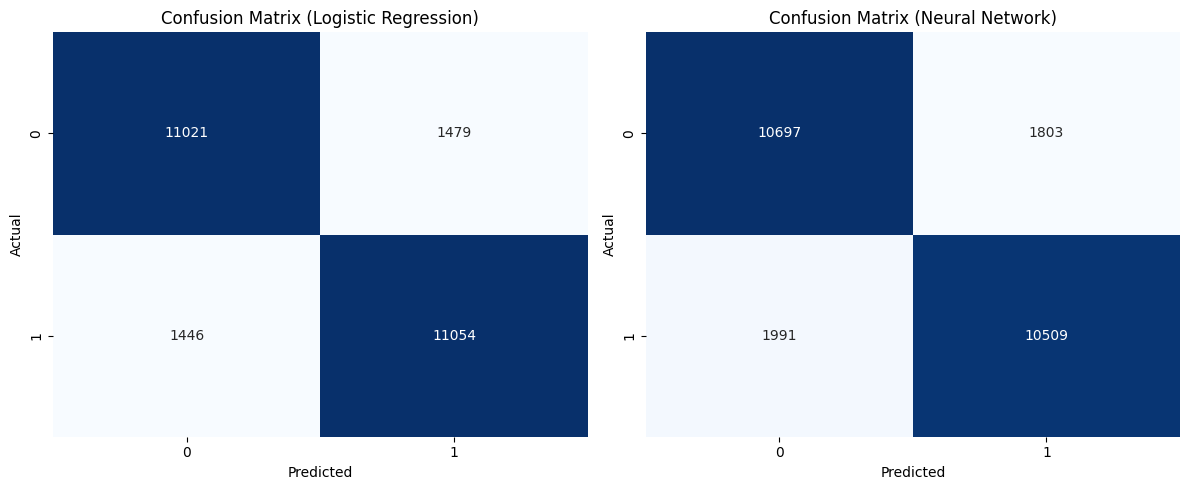

In [10]:
print("\n" + "="*50)
print("STEP 8: Visualization")
print("="*50)

# Plot training history
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

# Compare confusion matrices
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
cm_lr = confusion_matrix(y_test, y_pred)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix (Logistic Regression)')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 2, 2)
cm_nn = confusion_matrix(y_test, y_pred_nn)
sns.heatmap(cm_nn, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix (Neural Network)')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.savefig('confusion_matrices.png')
plt.show()


In [11]:
print("\n" + "="*50)
print("STEP 9: Model Application")
print("="*50)

# Function to test a custom review
def predict_sentiment(review_text, model_type='nn'):
    # Preprocess the input
    processed_text = preprocess_text(review_text)
    # Convert to TF-IDF
    features = tfidf_vectorizer.transform([processed_text])

    if model_type == 'lr':
        # Predict using logistic regression
        prediction = lr_model.predict(features)[0]
    else:
        # Convert to dense and predict using neural network
        features_dense = features.toarray()
        prediction_prob = model.predict(features_dense)[0][0]
        prediction = 1 if prediction_prob > 0.5 else 0

    sentiment = "Positive" if prediction == 1 else "Negative"
    return sentiment

# Example of using the prediction function
example_review = "This movie was absolutely fantastic! The acting was superb and the plot kept me engaged throughout."
print(f"\nExample review: {example_review}")
print(f"Logistic Regression prediction: {predict_sentiment(example_review, 'lr')}")
print(f"Neural Network prediction: {predict_sentiment(example_review, 'nn')}")

#######################################################
# Optional: Experiment with Different Epoch Numbers
#######################################################

def train_with_different_epochs(epochs_list=[5, 10, 15, 20]):
    """
    Optional function to experiment with different numbers of epochs.
    Uncomment and run this section to see how different epoch values affect performance.
    """
    results = []

    for num_epochs in epochs_list:
        print(f"\nTraining model with {num_epochs} epochs...")

        # Rebuild model
        temp_model = Sequential([
            Dense(128, activation='relu', input_shape=(X_train_tfidf_dense.shape[1],)),
            Dropout(0.5),
            Dense(64, activation='relu'),
            Dropout(0.3),
            Dense(1, activation='sigmoid')
        ])

        temp_model.compile(
            optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        # Train model
        history = temp_model.fit(
            X_train_final, y_train_final,
            epochs=num_epochs,
            batch_size=64,
            validation_data=(X_val, y_val),
            verbose=0
        )

        # Evaluate model
        test_loss, test_accuracy = temp_model.evaluate(X_test_tfidf_dense, y_test, verbose=0)
        val_accuracy = history.history['val_accuracy'][-1]

        results.append({
            'epochs': num_epochs,
            'val_accuracy': val_accuracy,
            'test_accuracy': test_accuracy
        })

    # Display results
    results_df = pd.DataFrame(results)
    print("\nResults with different epoch counts:")
    print(results_df)

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(results_df['epochs'], results_df['val_accuracy'], 'o-', label='Validation Accuracy')
    plt.plot(results_df['epochs'], results_df['test_accuracy'], 'o-', label='Test Accuracy')
    plt.title('Model Performance vs. Number of Epochs')
    plt.xlabel('Number of Epochs')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig('epochs_comparison.png')
    plt.show()

# Uncomment to run the epoch comparison experiment
# train_with_different_epochs()

print("\n" + "="*50)
print("COMPLETED ALL STEPS")
print("="*50)


STEP 9: Model Application

Example review: This movie was absolutely fantastic! The acting was superb and the plot kept me engaged throughout.
Logistic Regression prediction: Positive
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Neural Network prediction: Positive

COMPLETED ALL STEPS
